# **Introducción**

En este cuaderno se llevan a cabo tres **experimentos** con un modelo Aurora para predecir `thetao`, variando tanto los **criterios de entrenamiento** (congelamiento total/parcial de la red, *learning rate*) como el **tamaño de batch** (batch_size). Posteriormente, se realiza un proceso de **inferencia** con cada uno de los modelos resultantes y se evalúan distintas métricas (RMSE, Bias y ACC), además de **visualizar** algunas muestras predichas en comparación con el objetivo real.

Los **tres experimentos** principales son:

1. **Experimento 1**: Fine-tuning completo con LR = 1e-5.  
2. **Experimento 2**: Entrenamiento con toda la red congelada excepto el decodificador y LR = 1e-4.  
3. **Experimento 3**: Reemplazar (o descongelar completamente) toda la red con un nuevo decodificador y LR = 1e-5.

Adicionalmente, para cada uno de estos **experimentos**, se probaron **dos tamaños de batch**: 3 y 8.

---


In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
import xarray as xr
from tqdm import tqdm
from typing import List, Tuple

from aurora import Aurora, Batch, Metadata, normalisation, rollout



#dataset = xr.open_dataset("/Users/victormedina/Desktop/cmems_preprocessed_oceanographic_data.nc", engine="netcdf4")
#dataset = xr.open_dataset("D://Aaron///cmems_mod_glo_phy_my_0.083deg_P1D-m_v1_little.nc")
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m.nc").isel(time=slice(0,30))
#dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
dataset = xr.open_dataset("D://Aaron//cmems_mod_glo_phy_my_0.083deg_P1D-m_6years_thetao_v3.nc")
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m_v1.nc", engine="netcdf4") #dataset de 3 dias
#dataset = xr.open_dataset("/Users/victormedina/Desktop/TFG/Datos/cmems_mod_glo_phy_my_0.083deg_P1D-m.nc", engine="netcdf4") #dataset de 3 años que solo ejecuta en pc grande
dataset



c:\Users\Victor\miniconda3\envs\Aurora_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<xarray.Dataset> Size: 32GB
Dimensions:    (depth: 49, latitude: 180, longitude: 180, time: 2558)
Coordinates:
  * depth      (depth) float32 196B 0.494 1.541 2.646 ... 4.833e+03 5.275e+03
  * latitude   (latitude) float32 720B 19.58 19.67 19.75 ... 34.33 34.42 34.5
  * longitude  (longitude) float32 720B -20.92 -20.83 -20.75 ... -6.083 -6.0
  * time       (time) datetime64[ns] 20kB 2014-01-01 2014-01-02 ... 2021-01-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 32GB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.3.3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#importar variable 
lsm = xr.open_dataset("D://Aaron/datos_mascara.nc")

In [4]:

variables = ['thetao']  # Solo 'thetao'
dataset = dataset[variables]

# Cargar el dataset solo con la variable que necesitas
variables = ['thetao']  # Selecciona solo 'thetao'


# Filtrar por la profundidad (limitando el número de niveles de profundidad)
dataset = dataset.isel(depth=slice(0, 10))  # Limitar a los primeros 10 niveles de profundidad
ocean_levels = dataset['depth'].values

# Ajustar las longitudes para que coincidan en rango (de -180 a 180) y latitudes para interpolación
lsm_copy = lsm.copy()
lsm_copy = lsm_copy.assign_coords(longitude=(((lsm_copy.longitude + 180) % 360) - 180))

# Interpolar la variable lsm para que coincida con la resolución del dataset
lsm_interp = lsm_copy.interp(latitude=dataset.latitude, longitude=dataset.longitude, method="nearest")

# Asignar la variable lsm al dataset sin añadir coordenadas innecesarias
lsm_interp_clean = lsm_interp.fillna(0)  # Reemplazar los NaNs por ceros
dataset['lsm'] = lsm_interp_clean['lsm']

# Eliminar las coordenadas innecesarias si se añadieron automáticamente
coordinates_to_drop = ['number', 'step', 'surface', 'valid_time']
for coord in coordinates_to_drop:
    if coord in dataset.coords:
        dataset = dataset.drop_vars(coord)

# Verificar y ajustar las latitudes para asegurar que están en el orden correcto y dentro del rango adecuado
def check_latitudes(dataset: xr.Dataset) -> xr.Dataset:
    latitude = dataset['latitude'].values
    if not (np.all(latitude <= 90) and np.all(latitude >= -90)):
        raise ValueError("Algunos valores de latitud están fuera del rango [-90, 90]. Por favor, corrígelos.")
    if not np.all(np.diff(latitude) < 0):
        dataset = dataset.sortby('latitude', ascending=False)
    return dataset

# Ajustar las longitudes para que estén dentro del rango [0,360]
def check_longitudes(dataset: xr.Dataset) -> xr.Dataset:
    dataset = dataset.assign_coords(longitude=((dataset.longitude + 360) % 360))
    return dataset

# Aplicar funciones de verificación al dataset
dataset = check_latitudes(dataset)
dataset = check_longitudes(dataset)

# Convertir latitudes y longitudes a tensores de Torch para su posterior uso
latitude = torch.from_numpy(dataset['latitude'].values).float()
longitude = torch.from_numpy(dataset['longitude'].values).float()

# Revisar si hay valores NaN restantes después de la interpolación y eliminarlos si es necesario
dataset = dataset.dropna(dim="latitude", how="all").dropna(dim="longitude", how="all")

# Rellenar los valores NaN con la media de la variable
def fill_nan_with_mean(var: xr.DataArray) -> xr.DataArray:
    if var.isnull().any():
        return var.fillna(var.mean())
    else:
        return var

for var in variables:
    dataset[var] = fill_nan_with_mean(dataset[var])



In [5]:
# Definir funciones para cargar datos
def load_ocean_surface(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables de superficie para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable de superficie.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {}
        if 'depth' in sample_set[v].dims:
            sel_dict['depth'] = 0  # Seleccionar nivel superficial
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (lat, lon)


        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch (nueva dimensión 0)
    data_batch = torch.stack(data_list, dim=0)    # (batch_size, time, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, 1, lat, lon)

    return data_batch, target_batch




def load_ocean_atmos(v: str, sample_sets: list) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Carga los datos de variables atmosféricas para un conjunto de muestras.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Datos y targets concatenados de la variable atmosférica.
    """
    data_list = []
    target_list = []
    for sample_set in sample_sets:
        sel_dict = {'depth': slice(0, 10)}  # Seleccionar los primeros N niveles de profundidad
        data = sample_set[v].isel(**sel_dict).isel(time=slice(0, 2)).values  # (time, depth, lat, lon)
        data_tensor = torch.from_numpy(data).float()  # (time, depth, lat, lon)
        data_list.append(data_tensor)

        target = sample_set[v].isel(**sel_dict).isel(time=slice(2,None)).values  # (depth, lat, lon)
        target_tensor = torch.from_numpy(target).float()  # (depth, lat, lon)
        target_list.append(target_tensor)

    # Concatenar los datos a lo largo de la dimensión batch
    data_batch = torch.stack(data_list, dim=0)  # (batch_size, time, depth, lat, lon)
    target_batch = torch.stack(target_list, dim=0)  # (batch_size, depth, lat, lon)

    return data_batch, target_batch



def load_static_var(v: str, sample_sets: list) -> torch.Tensor:
    """
    Carga una variable estática del dataset.

    Args:
        v (str): Nombre de la variable.
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        torch.Tensor: Tensor con los datos de la variable estática (lat, lon).
    """
    # Since static variables are the same across the batch, we can take from the first sample
    sample_set = sample_sets[0]
    data_var = sample_set[v]
    dims_to_drop = [dim for dim in data_var.dims if dim not in ('latitude', 'longitude')]
    data_var = data_var.isel({dim: 0 for dim in dims_to_drop})
    data = data_var.values  # Should be (lat, lon)
    data_tensor = torch.from_numpy(data).float()

    return data_tensor  # Shape: (lat, lon)



In [6]:

surf_vars: tuple[str, ...] = ('thetao',)
static_vars: tuple[str, ...] = ('lsm',)
atmos_vars: tuple[str, ...] = ('thetao',)

# Crear el modelo Aurora y moverlo al dispositivo
model = Aurora(surf_vars=surf_vars, static_vars=static_vars, atmos_vars=atmos_vars, use_lora=False,autocast=True).to(device)
model.load_checkpoint("microsoft/aurora", "aurora-0.25-pretrained.ckpt", strict=False)
print("Modelo Aurora cargado y ajustado exitosamente.") 


Modelo Aurora cargado y ajustado exitosamente.


# Dividir el conjunto de Datos

In [7]:
#de cuando a cuando es el dataset
print(f"Rango de tiempo del conjunto total de datos: {dataset['time'].values[0]} a {dataset['time'].values[-1]}")

#Definir las estaciones del año según el mes (ya es un número entero)
# Definir las estaciones del año según el mes
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

# Aplicar la función get_season a la columna de meses del dataset usando dask
dataset['season'] = xr.apply_ufunc(
    np.vectorize(get_season),
    dataset['time'].dt.month,  # Usamos el mes directamente
    vectorize=True,
    dask="parallelized",  # Habilitar dask para procesamiento en paralelo
    output_dtypes=[str]  # Definir el tipo de salida
)
#Función para dividir el dataset respetando las estaciones y evitando solapamientos
def split_by_time(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide el dataset en entrenamiento, validación y prueba asegurando que todas las estaciones estén
    representadas en cada conjunto y no haya solapamientos temporales.

    Args:
        dataset_años (xr.Dataset): El dataset con la dimensión 'time'.
        train_ratio (float): Proporción de datos para el conjunto de entrenamiento.
        val_ratio (float): Proporción de datos para el conjunto de validación.
        test_ratio (float): Proporción de datos para el conjunto de prueba.

    Returns:
        train_dataset_años (xr.Dataset): Conjunto de entrenamiento con todas las estaciones.
        val_dataset_años (xr.Dataset): Conjunto de validación con todas las estaciones.
        test_dataset_años (xr.Dataset): Conjunto de prueba con todas las estaciones.
    """
    # Total de puntos temporales en el dataset
    num_times = len(dataset['time'])
    
    # Calcular los índices para dividir los datos
    train_index = int(train_ratio * num_times)
    val_index = int(val_ratio * num_times)
    
    # Crear los conjuntos secuencialmente por tiempo (sin solapamiento)
    train_dataset = dataset.isel(time=slice(0, train_index))
    val_dataset = dataset.isel(time=slice(train_index, train_index + val_index))
    test_dataset = dataset.isel(time=slice(train_index + val_index, num_times))

    # Ahora aseguramos que cada conjunto tenga ejemplos de todas las estaciones
    def ensure_all_seasons(dataset):
        # Verificar qué estaciones están presentes en este dataset
        seasons_present = np.unique(dataset['season'].values)
        missing_seasons = set(['winter', 'spring', 'summer', 'fall']) - set(seasons_present)
        
        if missing_seasons:
            raise ValueError(f"El dataset no tiene datos de las estaciones: {missing_seasons}")
        return dataset
    
    train_dataset = ensure_all_seasons(train_dataset)
    val_dataset = ensure_all_seasons(val_dataset)
    test_dataset = ensure_all_seasons(test_dataset)

    return train_dataset, val_dataset, test_dataset

# Llamar a la función para dividir el dataset secuencialmente y asegurar que contenga todas las estaciones
train_dataset, val_dataset, test_dataset = split_by_time(dataset)
#Imprimir tamaños y rangos de los conjuntos de datos resultantes
print(f"Conjunto de entrenamiento: {len(train_dataset['time'])} instancias temporales")
print(f"Conjunto de validación: {len(val_dataset['time'])} instancias temporales")
print(f"Conjunto de prueba: {len(test_dataset['time'])} instancias temporales")

print(f"Rango de tiempo del conjunto de entrenamiento: {train_dataset['time'].values[0]} a {train_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de validación: {val_dataset['time'].values[0]} a {val_dataset['time'].values[-1]}")
print(f"Rango de tiempo del conjunto de prueba: {test_dataset['time'].values[0]} a {test_dataset['time'].values[-1]}")

Rango de tiempo del conjunto total de datos: 2014-01-01T00:00:00.000000000 a 2021-01-01T00:00:00.000000000
Conjunto de entrenamiento: 1790 instancias temporales
Conjunto de validación: 383 instancias temporales
Conjunto de prueba: 385 instancias temporales
Rango de tiempo del conjunto de entrenamiento: 2014-01-01T00:00:00.000000000 a 2018-11-25T00:00:00.000000000
Rango de tiempo del conjunto de validación: 2018-11-26T00:00:00.000000000 a 2019-12-13T00:00:00.000000000
Rango de tiempo del conjunto de prueba: 2019-12-14T00:00:00.000000000 a 2021-01-01T00:00:00.000000000


In [8]:
train_ocean_levels = train_dataset['depth'].values

# Normalización para thetao en los niveles oceánicos
for level in train_ocean_levels:
    level_str = f"{level}"
    var = "thetao"
    data = train_dataset[var].sel(depth=level).values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[f"{var}_{level_str}"] = mean
    normalisation.scales[f"{var}_{level_str}"] = std

# Normalización para thetao en la superficie
surface_vars = ["thetao"]
for var in surface_vars:
    if 'depth' in train_dataset[var].dims:
        data = train_dataset[var].isel(depth=0).values
    else:
        data = train_dataset[var].values
    mean = np.nanmean(data)
    std = np.nanstd(data)
    normalisation.locations[var] = mean
    normalisation.scales[var] = std

print("Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.")



Variable  thetao  actualizadas exitosamente con el conjunto de entrenamiento.


In [9]:
class BatchGenerator:
    def __init__(self, dataset: xr.Dataset, sample_size: int, batch_size: int, shuffle: bool = True, padding: bool = True):
        """
        Inicializa el BatchGenerator.

        Args:
            dataset (xr.Dataset): El conjunto de datos.
            sample_size (int): Tamaño de cada ventana deslizante.
            batch_size (int): Tamaño de cada batch.
            shuffle (bool): Si se deben barajar las muestras.
            padding (bool): Si se debe aplicar padding al último batch.
        """
        self.dataset = dataset
        self.sample_size = sample_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding = padding
        self.samples = self.generate_sliding_windows()
        if self.shuffle:
            self.samples = self.shuffle_samples()

    def generate_sliding_windows(self):
        """
        Genera ventanas deslizantes sobre el eje temporal del dataset.

        Returns:
            list: Lista de muestras generadas mediante ventanas deslizantes.
        """
        window_size = self.sample_size
        windows = [slice(i, i + window_size) for i in range(0, len(self.dataset.time) - window_size + 1)]
        samples = [self.dataset.isel(time=w) for w in windows]
        return samples

    def shuffle_samples(self):
        """
        Baraja las muestras generadas.

        Returns:
            list: Lista de muestras barajadas.
        """
        samples_copy = self.samples.copy()
        np.random.shuffle(samples_copy)
        return samples_copy

    def load_ocean_batch(self, sample_sets):
        """
    Carga un batch de datos a partir de un conjunto de muestras.

    Args:
        sample_sets (list): Lista de conjuntos de datos de muestra.

    Returns:
        Tuple[Batch, Batch]: Batch de datos y batch de targets.
        """
        is_padding = any(sample.attrs.get('is_padding', False) for sample in sample_sets)

    # Llamar a las funciones de carga modificadas
        surf_data, surf_target = load_ocean_surface("thetao", sample_sets)
        atmos_data, atmos_target = load_ocean_atmos("thetao", sample_sets)
        static_data = load_static_var("lsm", sample_sets).to(device)

        times = [
            sample_set['time'].values[-1].astype('datetime64[s]').astype(datetime)
            for sample_set in sample_sets
        ]
    # Crear instancia de Batch para el batch completo
        batch = Batch(
            surf_vars={
                "thetao": surf_data,
            },
            static_vars={
                "lsm": static_data,
            },
            atmos_vars={
                "thetao": atmos_data,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch.metadata.is_padding = is_padding

        batch_target = Batch(
            surf_vars={
                "thetao": surf_target,
            },
            static_vars={
             "lsm": static_data,  # Asumimos que los static_vars son iguales para data y target
            },
            atmos_vars={
                "thetao": atmos_target,
            },
            metadata=Metadata(
                lat=latitude,
                lon=longitude,
                time=times,
                atmos_levels=ocean_levels,
            )
        )
        batch_target.metadata.is_padding = is_padding

        return batch, batch_target


    def __iter__(self):
        """
        Iterador que genera batches de datos.

        Yields:
            Tuple[list, list]: Batch de datos y batch de targets.
        """
        # Dividimos las muestras en batches
        for i in range(0, len(self.samples), self.batch_size):
            batch_samples = self.samples[i:i + self.batch_size]

            # Aplicamos padding si es necesario
            if len(batch_samples) < self.batch_size and self.padding:
                num_padding = self.batch_size - len(batch_samples)
                for _ in range(num_padding):
                    sample = self.samples[i % len(self.samples)]
                    sample = sample.copy()
                    sample.attrs['is_padding'] = True
                    batch_samples.append(sample)

            batch, batch_target = self.load_ocean_batch(batch_samples)
            yield batch, batch_target


In [10]:
import numpy as np

class Metricas:
    def __init__(self, latitudes):
        """ Inicializa la clase con latitudes y calcula las ponderaciones normalizadas. """
        self.latitudes = latitudes
        # Convertir latitudes a radianes
        lat_rad = np.deg2rad(self.latitudes)
        # Calcular los pesos y normalizar
        weights = np.cos(lat_rad)
        normalization_factor = np.mean(weights)
        self.weights = (weights / normalization_factor).reshape(1, -1, 1)
        
    
    def rmse(self, pred, target):
        """ Calcula el RMSE ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        
        # Calcular los errores cuadrados
        errors_squared = (pred - target) ** 2
        # Aplanar los arrays
        errors_squared_flat = errors_squared.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(errors_squared_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        errors_squared_flat = errors_squared_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular la media ponderada de los errores cuadrados
        mse_weighted = np.average(errors_squared_flat, weights=weights_flat)
        rmse_weighted = np.sqrt(mse_weighted)
        return rmse_weighted
    
    def bias(self, pred, target):
        """ Calcula el sesgo ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Calcular las diferencias
        differences = pred - target
        # Aplanar los arrays
        differences_flat = differences.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(differences_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        differences_flat = differences_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular el Bias ponderado
        bias_weighted = np.average(differences_flat, weights=weights_flat)
        return bias_weighted
    
    def acc(self, pred, target):
        """ Calcula el Coeficiente de Correlación de Anomalías (ACC) ponderado entre pred y target. """
        # Expandir las ponderaciones
        weights_full = np.tile(self.weights, (pred.shape[0], 1, pred.shape[2]))
        
        # Aplanar los arrays
        pred_flat = pred.reshape(-1)
        target_flat = target.reshape(-1)
        weights_flat = weights_full.reshape(-1)
        # Crear una máscara para eliminar valores NaN
        mask = ~np.isnan(pred_flat) & ~np.isnan(target_flat) & ~np.isnan(weights_flat)
        # Aplicar la máscara
        pred_flat = pred_flat[mask]
        target_flat = target_flat[mask]
        weights_flat = weights_flat[mask]
        
        
        # Calcular las medias ponderadas
        pred_mean = np.average(pred_flat, weights=weights_flat)
        target_mean = np.average(target_flat, weights=weights_flat)
        
        
        # Calcular las anomalías
        pred_anomaly = pred_flat - pred_mean
        target_anomaly = target_flat - target_mean
        
        # Calcular covarianza y varianzas ponderadas
        covariance = np.average(pred_anomaly * target_anomaly, weights=weights_flat)
        pred_variance = np.average(pred_anomaly ** 2, weights=weights_flat)
        target_variance = np.average(target_anomaly ** 2, weights=weights_flat)
        
        
        # Calcular el ACC
        denominator = np.sqrt(pred_variance * target_variance)
        if denominator != 0:
            acc_weighted = covariance / denominator
        else:
            acc_weighted = np.nan
            print("El denominador es cero, ACC no está definido.")
        return acc_weighted


In [11]:

# Rutas de los modelos
model_paths = [
    'C://Users//Victor//Desktop//modelo//aurora_exp1_bs3.pth',
    'C://Users//Victor//Desktop//modelo//aurora_exp2_bs3.pth',
    'C://Users//Victor//Desktop//modelo//aurora_exp3_bs3.pth',
    'C://Users//Victor//Desktop//modelo//aurora_exp1_bs8.pth',
    'C://Users//Victor//Desktop//modelo//aurora_exp2_bs8.pth',
    'C://Users//Victor//Desktop//modelo//aurora_exp3_bs8.pth', 
]


# Crear generador de batches para el conjunto de prueba
batch_size = 3
test_generator = BatchGenerator(test_dataset, sample_size=3, batch_size=batch_size, shuffle=False, padding=False)

C:\Users\Victor\AppData\Local\Temp\ipykernel_17384\81862747.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
c:\Users\Victor

Resultados del modelo para el experimento 1 con batch_size = 3:
RMSE: 0.13121891021728516
Bias: -0.06888528168201447
ACC: 0.9974396228790283


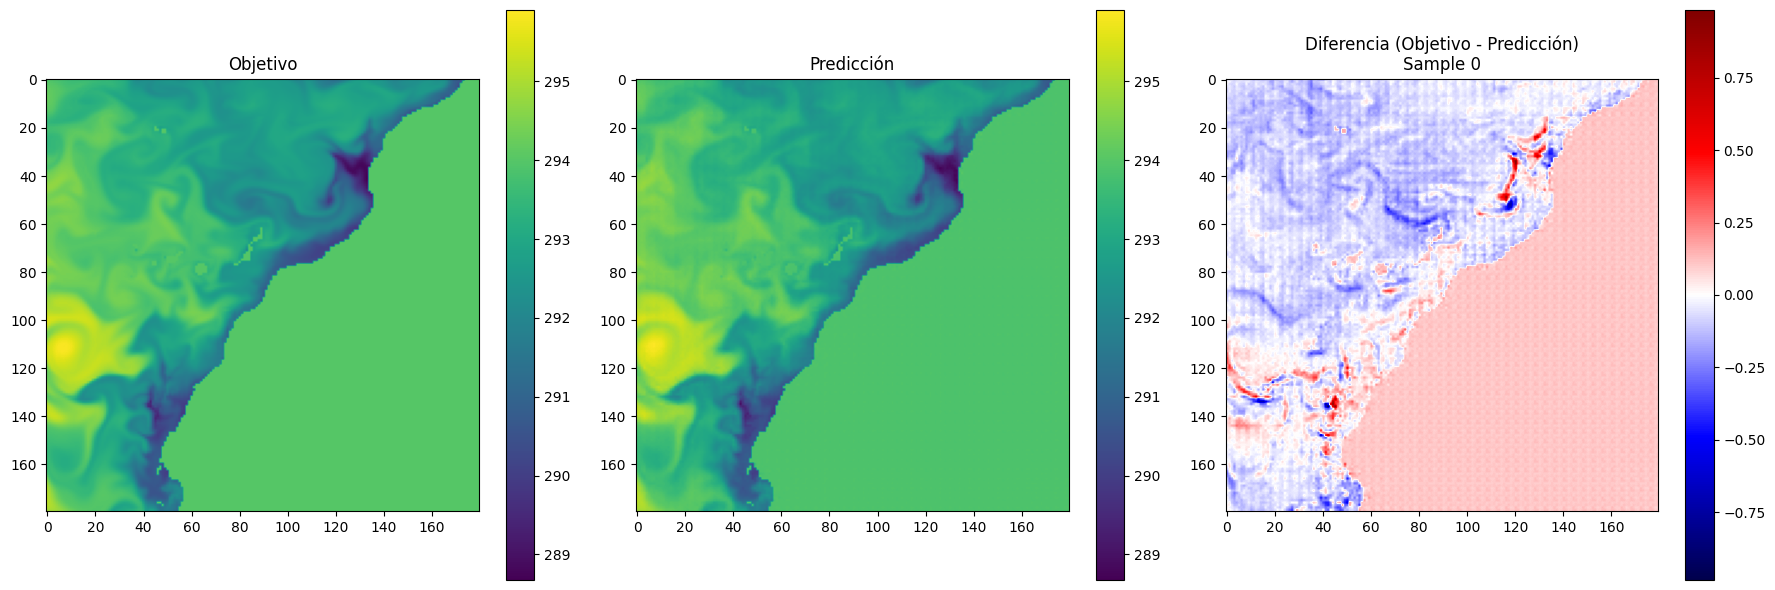

Resultados del modelo para el experimento 2 con batch_size = 3:
RMSE: 0.14000502228736877
Bias: -0.06436159461736679
ACC: 0.9967402815818787


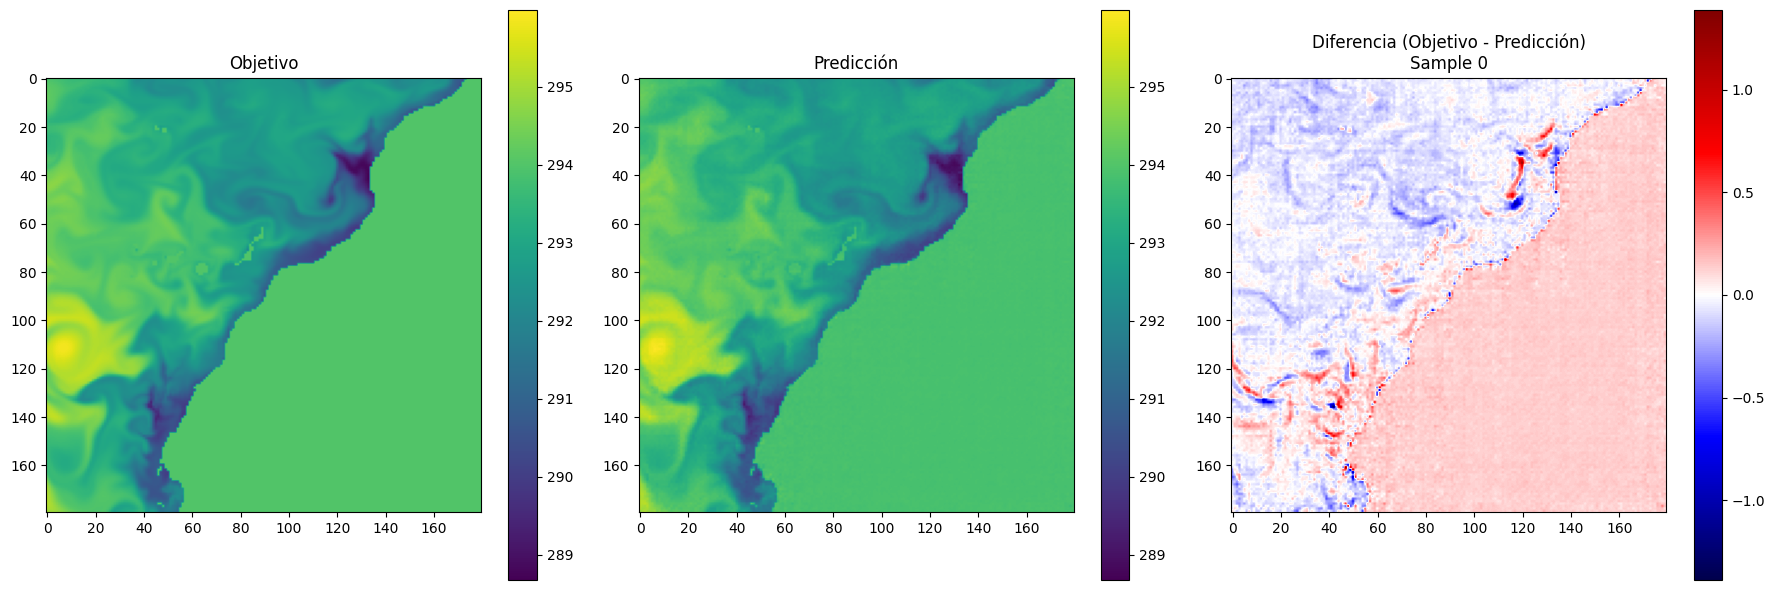

Resultados del modelo para el experimento 3 con batch_size = 3:
RMSE: 0.12475558370351791
Bias: -0.06410764902830124
ACC: 0.9975794553756714


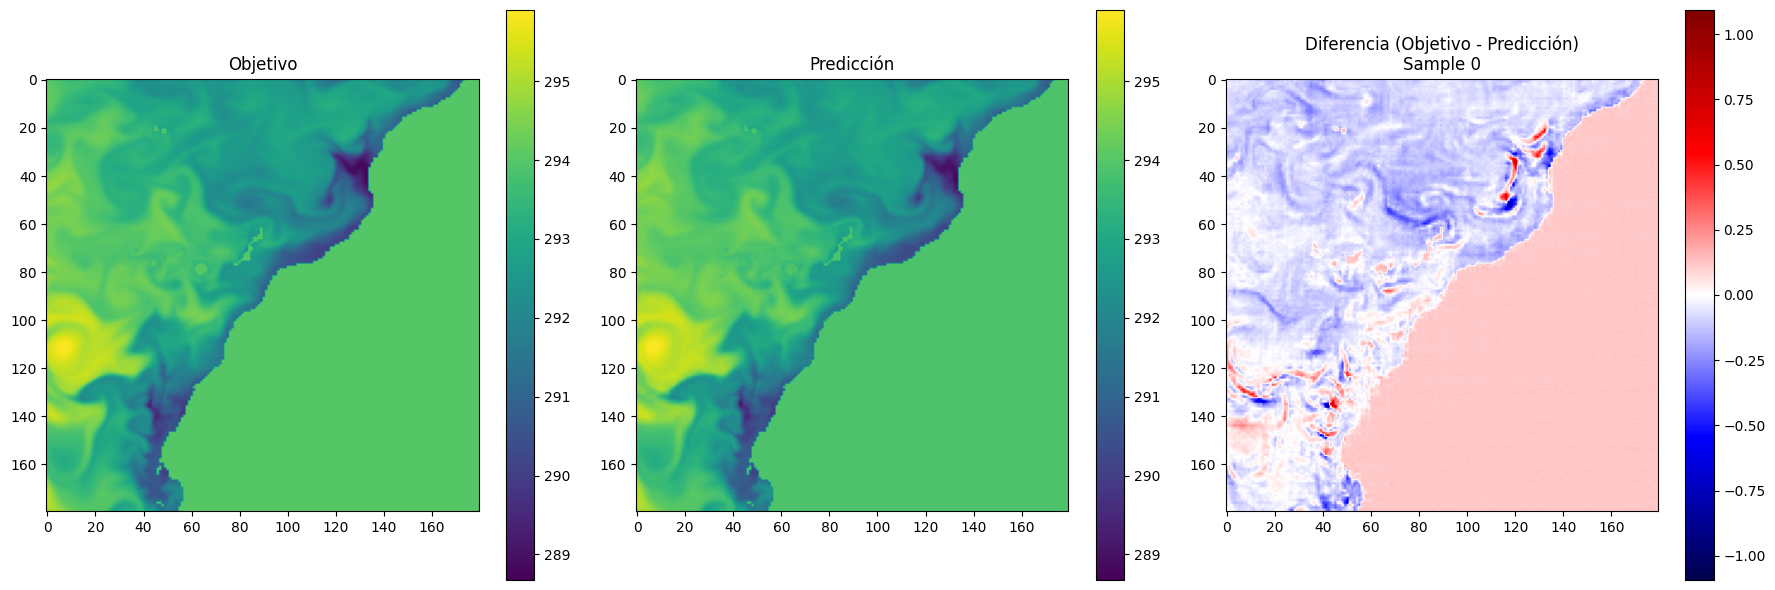

Resultados del modelo para el experimento 1 con batch_size = 8:
RMSE: 0.13008616864681244
Bias: -0.06235356256365776
ACC: 0.9972302317619324


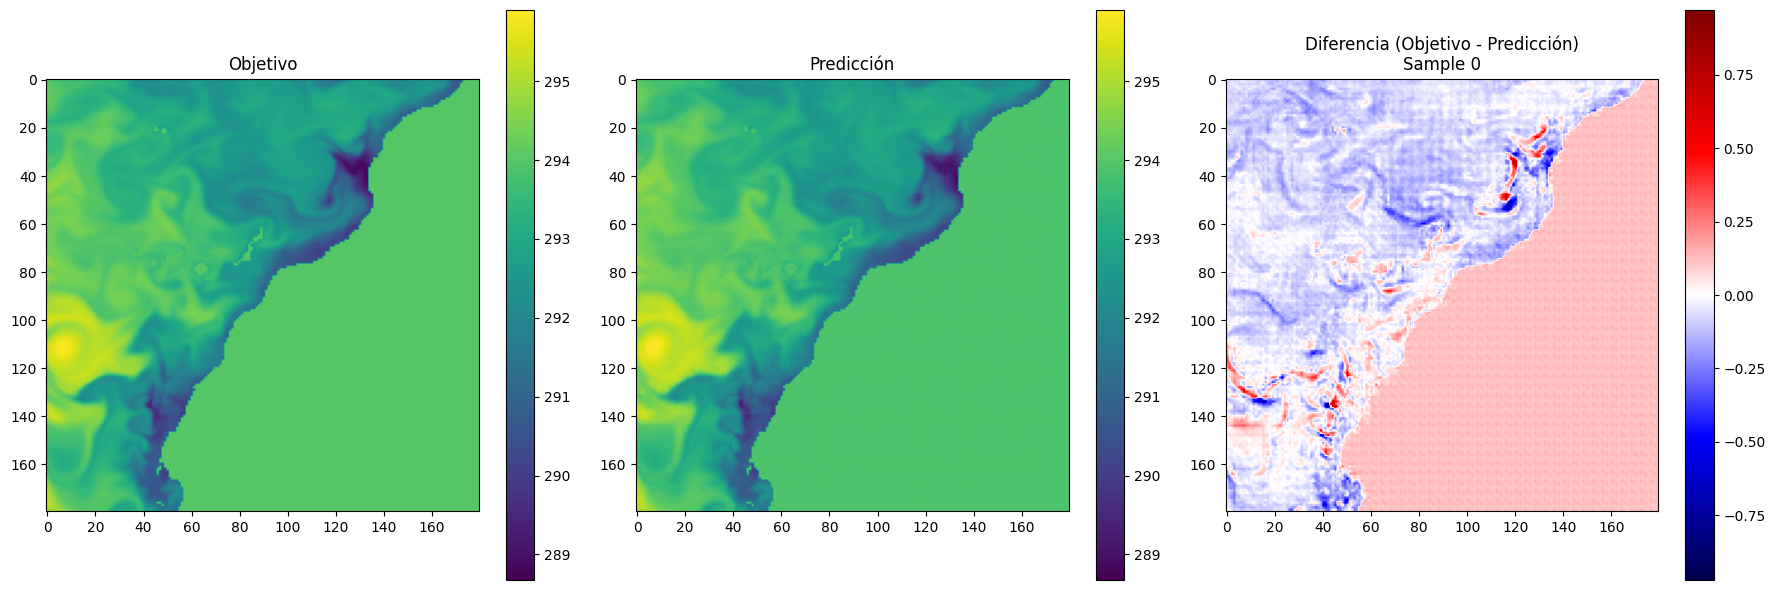

Resultados del modelo para el experimento 2 con batch_size = 8:
RMSE: 0.13522998988628387
Bias: -0.05934884399175644
ACC: 0.9968677759170532


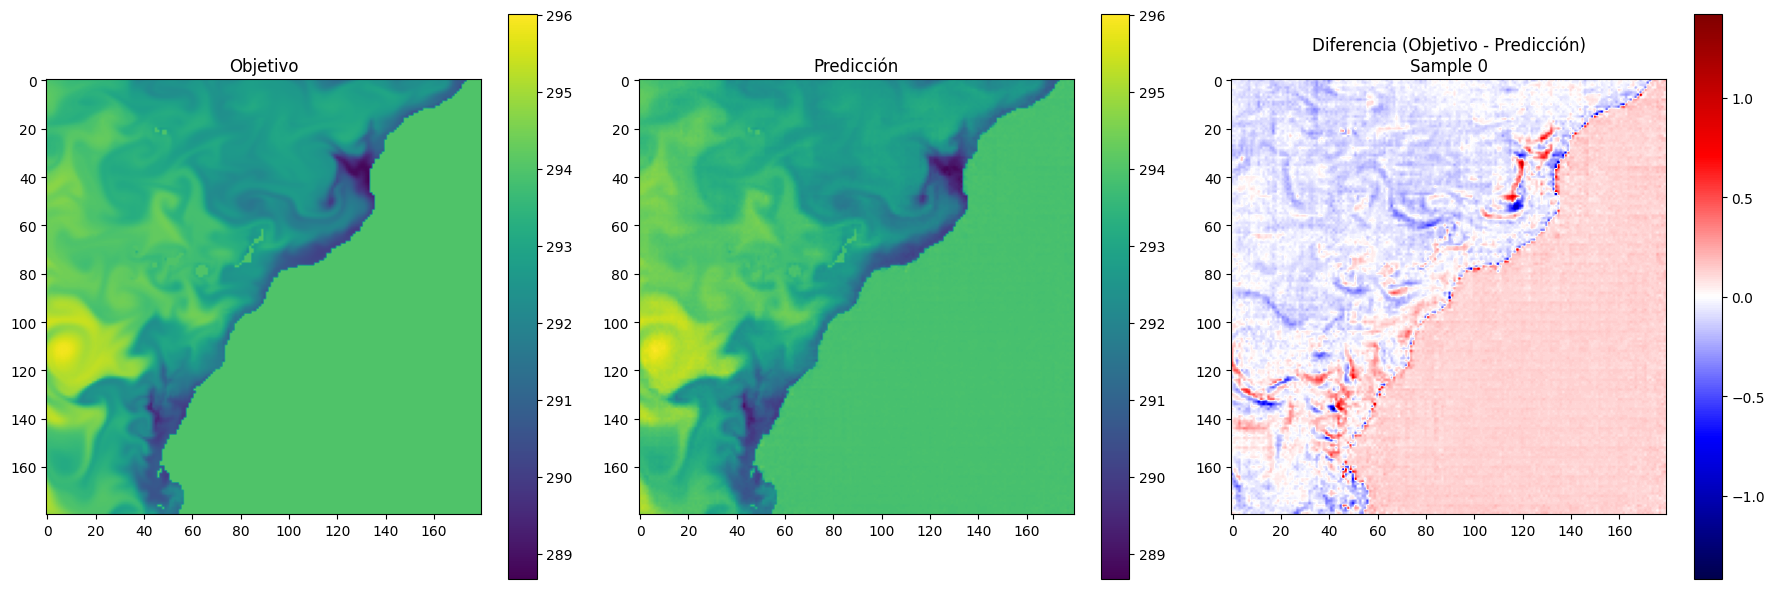

Resultados del modelo para el experimento 3 con batch_size = 8:
RMSE: 0.13458022475242615
Bias: -0.033878207206726074
ACC: 0.9967272281646729


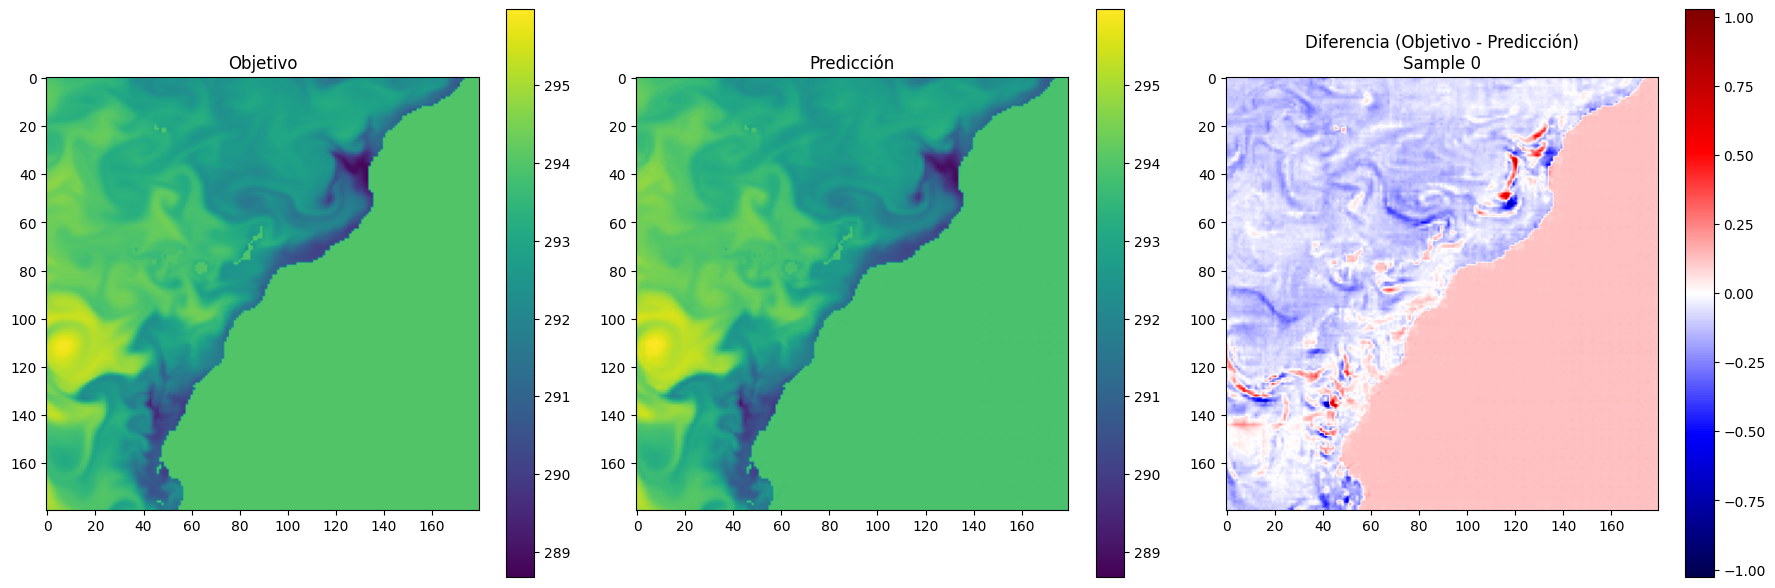

In [12]:


latitudes = dataset['latitude'].values
metricas = Metricas(latitudes)
# Inferencia y evaluación
for model_idx, model_path in enumerate(model_paths):
    # Cargar el modelo
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Listas para almacenar resultados
    predictions = []
    targets = []
    timestamps = []

    # Inferencia
    for batch, batch_target in test_generator:
        if getattr(batch.metadata, 'is_padding', False):
            continue  # Ignorar los batches con padding

        target = batch_target.surf_vars['thetao'].to(device)
        targets.append(target.cpu().numpy())
        timestamps.extend(batch.metadata.time)

        with torch.no_grad():
            outputs = [out.to(device) for out in rollout(model, batch, steps=1)]
            model_output = outputs[0]
            prediction = model_output.surf_vars['thetao'].cpu().numpy()
            predictions.append(prediction)

    # Convertir listas en arreglos numpy
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Calcular métricas
    rmse = metricas.rmse(predictions, targets)
    bias = metricas.bias(predictions, targets)
    acc = metricas.acc(predictions, targets)

    # Calcular el número de experimento
    experiment_num = (model_idx % 3) + 1  # Cicla entre 1, 2, 3

    # Determinar el tamaño del lote según el modelo
    batch_size = 3 if model_idx < 3 else 8

    # Imprimir resultados del modelo
    print(f"Resultados del modelo para el experimento {experiment_num} con batch_size = {batch_size}:")
    print(f"RMSE: {rmse}")
    print(f"Bias: {bias}")
    print(f"ACC: {acc}")

    # Visualizaciones
    def plot_target_prediction(target, prediction, timestamp, idx):
        # Ajustar dimensiones para visualización
        target_img = target.squeeze()
        prediction_img = prediction.squeeze()
        difference_img = target_img - prediction_img

        plt.figure(figsize=(18, 6))

        # Escala de color común
        vmin = min(target_img.min(), prediction_img.min())
        vmax = max(target_img.max(), prediction_img.max())

        # Graficar target
        plt.subplot(1, 3, 1)
        plt.imshow(target_img, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.title('Objetivo')
        plt.colorbar()

        # Graficar predicción
        plt.subplot(1, 3, 2)
        plt.imshow(prediction_img, cmap='viridis', vmin=vmin, vmax=vmax)
        plt.title('Predicción')
        plt.colorbar()

        # Graficar diferencia
        plt.subplot(1, 3, 3)
        diff_vmax = np.max(np.abs(difference_img))
        plt.imshow(difference_img, cmap='seismic', vmin=-diff_vmax, vmax=diff_vmax)
        plt.title(f'Diferencia (Objetivo - Predicción)\nSample {idx}')
        plt.colorbar()

        plt.tight_layout()
        plt.show()

    # Visualizar algunas muestras
    idx = 0  # Cambia según la muestra deseada
    if idx < len(predictions):
        target_sample = targets[idx]
        prediction_sample = predictions[idx]
        timestamp_sample = timestamps[idx * batch_size:(idx + 1) * batch_size]

        for i in range(target_sample.shape[0]):
            plot_target_prediction(
                target_sample[i], 
                prediction_sample[i], 
                timestamp_sample[i], 
                idx=idx * batch_size + i
            )
    else:
        print("Index out of range.")


# **Resultados de la Inferencia**

Tras entrenar los distintos modelos, se cargan en modo evaluación (`model.eval()`) y se corre un **rollout** de un paso (`steps=1`) en el conjunto de **prueba**. Luego se calculan las métricas *RMSE*, *Bias* y *ACC*, definidas con un **ponderador latitudinal** (cósmico).

A continuación, se muestran los resultados (RMSE, Bias y ACC) para cada experimento y distinto batch size:

| Experimento | batch_size | RMSE   | Bias      | ACC       |
|-------------|------------|--------|-----------|-----------|
| **Exp. 1** (LR=1e-5, fine-tuning completo) | 3  | 0.1312 | -0.0689   | 0.99744  |
| **Exp. 2** (LR=1e-4, red congelada salvo decoder) | 3  | 0.1400 | -0.0644   | 0.99674  |
| **Exp. 3** (LR=1e-5, descongelado completo + nuevo decoder) | 3  | 0.1248 | -0.0641   | 0.99758  |
| **Exp. 1** (LR=1e-5, fine-tuning completo) | 8  | 0.1301 | -0.0624   | 0.99723  |
| **Exp. 2** (LR=1e-4, red congelada salvo decoder) | 8  | 0.1352 | -0.0593   | 0.99687  |
| **Exp. 3** (LR=1e-5, descongelado completo + nuevo decoder) | 8  | 0.1346 | -0.0339   | 0.99673  |

De estos valores se aprecia lo siguiente:

- **RMSE** se mantiene alrededor de 0.12–0.14 en la mayoría de casos, lo que indica una buena aproximación del modelo a la verdad de `thetao`.
- **Bias** (sesgo) tiende a valores negativos próximos a 0, sugiriendo que el modelo, en promedio, **tiende a subestimar** levemente la temperatura.
- **ACC** (coeficiente de correlación de anomalías) supera consistentemente **0.996**, un valor muy alto que evidencia una fuerte correlación entre la predicción y el objetivo.

### Diferencias con el batch_size
Para batch_size = 3 y batch_size = 8, se observan **valores de RMSE, Bias y ACC** muy similares. Esto apunta a que el cambio de batch size no altera drásticamente las métricas finales de desempeño, al menos en estos experimentos.

---

# **Visualizaciones de Predicciones**

Además de calcular métricas, se han graficado algunas muestras de predicción vs objetivo real:

1. **Mapa objetivo** (Target).
2. **Mapa de predicción** (Prediction).
3. **Mapa de diferencias** (Objetivo - Predicción).

Estos gráficos permiten apreciar la **distribución espacial** de la temperatura y cómo la predicción se acerca (o difiere) en ciertas zonas. Por ejemplo, el diferencial más notorio puede darse en áreas costeras o de fuertes gradientes de temperatura. El hecho de que las diferencias (en la mayoría de los casos) sean moderadas, respalda la efectividad de los modelos entrenados.

---

# **Conclusión**

Este cuaderno demuestra:

1. **Inferencia robusta** para diferentes configuraciones de entrenamiento (exp1, exp2, exp3) y batch_size (3 u 8).  
2. **Resultados estables** en las métricas (RMSE, Bias y ACC) en cada experimento:  
   - El RMSE se mantiene entre ~0.12 y 0.14,  
   - El sesgo (Bias) ronda ~ -0.06,  
   - El ACC, por encima de ~0.996, denota alta correlación.  
3. **Visualizaciones** que corroboran la cercanía espacial entre predicción y objetivo, con diferencias moderadas.

Esto confirma la **capacidad generalizadora** de Aurora en la predicción de `thetao`, independientemente de la estrategia de congelamiento/descongelamiento utilizada y con distintos tamaños de lote. Sin embargo, la **elección final** de la estrategia de entrenamiento dependerá de limitaciones computacionales, el tiempo disponible y la fineza de ajuste que se busque alcanzar.